In [1]:
import pandas as pd
import datetime
import sys
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier
import re
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 训练数据集

In [2]:
# 认证信息表特征 120929 x 7

# 身份证号、认证时间、电话、申请贷款唯一编号
train_auth = pd.read_csv('AI_risk_train_V3.0/train_auth_info.csv',parse_dates = ['auth_time']) # parse_dates指定特征转化为时间

#注册时是否有时间
train_auth['is_auth_time_authtable'] = train_auth['auth_time'].map(lambda x:0 if str(x) == 'NaT'  else 1)
#注册时是否有idcard
train_auth['is_idcard_authtable'] = train_auth['id_card'].map(lambda x:0 if str(x)=='nan' else 1)

#注册时是否有phone
train_auth['is_phone_authtable'] = train_auth['phone'].map(lambda x:0 if str(x)=='nan' else 1)

In [3]:
train_auth.head()

,id_card,auth_time,phone,id,is_auth_time_authtable,is_idcard_authtable,is_phone_authtable
0,4****************0,2017-06-10,132****2008,501951980776722440,1,1,1
1,NaN,NaT,187*****500,525890212484616200,0,0,1
2,5****************9,2015-10-10,135****3522,599309364691472392,1,1,1
3,NaN,NaT,136*****651,582559913071350024,0,0,1
4,3****************0,2016-12-19,137****4241,599017959926534408,1,1,1


In [5]:
#%%银行卡特征   315489 x 6


# 银行卡名称、卡号后四位、类型、电话、申请贷款唯一编号
train_bankcard = pd.read_csv('AI_risk_train_V3.0/train_bankcard_info.csv')
# 每个id的不同银行卡的个数
bank_name_setlen = train_bankcard.groupby(by= ['id'], as_index= False)['bank_name'].agg({'bank_name_len':'nunique'})#lambda x:len(set(x))
# 每个id的手机后四位个数
bank_num_len = train_bankcard.groupby(by= ['id'], as_index = False)['tail_num'].agg({'tail_num_len':'count'})# lambda x:len(x)
# 每个id不同手机号的个数
bank_phone_num_setlen = train_bankcard.groupby(by= ['id'], as_index = False)['phone'].agg({'bank_phone_num':'nunique'})#lambda x:x.nunique()
# 将银行卡类型转化为相应的权重
train_bankcard['card_type_score'] = train_bankcard['card_type'].map(lambda x:0.0154925 if x=='信用卡' else 0.02607069)
# 每个id银行卡类型得分的均值
bank_card_type_score = train_bankcard.groupby(by= ['id'], as_index = False)['card_type_score'].agg({'card_type_score_mean':np.mean})


In [6]:
train_bankcard.head()

,bank_name,tail_num,card_type,phone,id,card_type_score
0,中信银行,9753,储蓄卡,177****8427,585401206734589960,0.026071
1,农业银行,2174,储蓄卡,150****4551,587694980785508360,0.026071
2,中国交通银行,4832,信用卡,185****1989,602098357531316232,0.015492
3,北京银行,5697,储蓄卡,186****1634,567205103669350408,0.026071
4,中信银行,7703,储蓄卡,158****7655,577538085852549384,0.026071


In [8]:
#%%网购平台信用信息特征

# {credit_score:'网购平台信用评分',overdraft:'网购平台信用额度使用值',quota:'网购平台信用额度',id:'申请贷款唯一编号'}
train_credit = pd.read_csv('AI_risk_train_V3.0/train_credit_info.csv')
#剩余额度
train_credit['can_use_credittable'] = train_credit['quota'] - train_credit['overdraft']

print(train_credit.shape)
train_credit.head()

(120929, 5)


,credit_score,overdraft,quota,id,can_use_credittable
0,549.0,0.0,0.0,563888070781309192,0.0
1,400.0,0.0,0.0,591567740590887176,0.0
2,490.0,4955.9,5083.0,464888846169936136,127.1
3,387.0,0.0,0.0,514996919311798280,0.0
4,394.0,0.0,0.0,20160629090004442243,0.0


In [9]:
#%%订单信息表特征 2415645×10 

# {amt_order:'订单金额',type_pay:'支付方式',time_order:'下单时间',sts_order:'订单状态',phone:'收货电话',
# unit_price:'商品单价',id:'申请贷款唯一编号',no_order_md5:'订单编号md5加密',name_rec_md5:'收货人姓名md5加密',
# product_id_md5:'收货编号md5加密'}
train_order = pd.read_csv('AI_risk_train_V3.0/train_order_info.csv',parse_dates=['time_order'])
train_order['amt_order_ordertable'] = train_order['amt_order'].map(lambda x:np.nan if ((x == 'NA')| (x == 'null')) else float(x))
train_order['unit_price_ordertable'] = train_order['unit_price'].map(lambda x:np.nan if ((x == 'NA')| (x == 'null')) else float(x))

train_order['time_order_ordertable'] = train_order['time_order'].map(lambda x : pd.lib.NaT if (str(x) == '0' or x == 'NA' or x == 'nan')
                            else (datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S') if ':' in str(x)
                            else (datetime.datetime.utcfromtimestamp(int(x[0:10])) + datetime.timedelta(hours = 8))))


print(train_order.shape)
train_order.head()

(2415645, 13)


,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5,amt_order_ordertable,unit_price_ordertable,time_order_ordertable
0,39.0,在线支付,2017-04-15 09:21:18,等待收货,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN,39.0,NaN,2017-04-15 09:21:18
1,39.0,在线支付,2017-04-15 09:21:18,完成,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN,39.0,NaN,2017-04-15 09:21:18
2,288.0,在线支付,2016-10-24 08:57:06,NaN,137****8223,NaN,609460154345197832,1d7b1294cdbfe24815e39c458cd059d1,eac9416f834d481d7c88da6134468d03,NaN,288.0,NaN,2016-10-24 08:57:06
3,428.0,在线支付,2016-10-27 20:04:48,完成,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN,428.0,NaN,2016-10-27 20:04:48
4,428.0,在线支付,2016-10-27 20:04:48,NaN,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN,428.0,NaN,2016-10-27 20:04:48


In [10]:
#%%收货地址信息特征 261299 x6

#{addr_id:'收货地址id',region:'收货地址所在地区',phone:'收货人手机号',fix_phone:'收货人固定电话',receiver_md5,'收货人姓名md5加密'}
train_recieve = pd.read_csv('AI_risk_train_V3.0/train_recieve_addr_info.csv')
train_recieve['region_province'] = train_recieve['region'].map(lambda x:str(x)[:2]) # 只取前面两位，即省份
train_recieve['region_district'] = train_recieve['region'].map(lambda x:str(x)[-1])

In [11]:
train_recieve.head()

,addr_id,region,phone,fix_phone,id,receiver_md5,region_province,region_district
0,NaN,NaN,NaN,NaN,575150029610684424,NaN,na,n
1,137816020.0,辽宁营口市鲅鱼圈区芦屯镇,186****4600,186****4600,563888070781309192,798371eaefb014d304e8c90ba0af1d09,辽宁,镇
2,137630418.0,辽宁营口市鲅鱼圈区红海街道,159****1000,159****1000,563888070781309192,41c14ef94733b4587f11ffb64e58a72d,辽宁,道
3,137816021.0,辽宁营口市鲅鱼圈区芦屯镇,186****4600,NaN,563888070781309192,798371eaefb014d304e8c90ba0af1d09,辽宁,镇
4,138135925.0,辽宁营口市鲅鱼圈区芦屯镇,189****9687,189****9687,563888070781309192,2d3e7dc595265a37f1e9eee82a15b047,辽宁,镇


In [12]:
#%%用户信息表特征    120929 x 12


# {sex:'性别',birthday:'出生日期',hobby:'兴趣爱好',merriage:'婚姻状况',income:'收入水平',
# id_card:'身份证号',degree:'学历',industry:'行业',qq_bound:'是否绑定qq',wechat_bound:'是否绑定微信',account_grade:'会员级别'}

train_user = pd.read_csv('AI_risk_train_V3.0/train_user_info.csv')
#train_user = train_user.drop(['merriage','income','id_card','degree','industry'],axis=1)
train_user = train_user.drop(['id_card'],axis=1)
train_user['is_hobby_usertable'] = train_user['hobby'].map(lambda x:0 if str(x).lower()=='nan'  else 1)
train_user['birthday'] = train_user['birthday'].map(lambda x:datetime.datetime.strptime(str(x),'%Y-%m-%d') if(re.match('19\d{2}-\d{1,2}-\d{1,2}',str(x)) and '-0' not in str(x)) else pd.lib.NaT)
train_user['is_birthday_usertable'] = train_user['birthday'].map(lambda x:0 if str(x).lower() == 'nat' else 1)

train_user.head()

,sex,birthday,hobby,merriage,income,degree,industry,qq_bound,wechat_bound,account_grade,id,is_hobby_usertable,is_birthday_usertable
0,保密,NaT,NaN,NaN,NaN,NaN,NaN,未绑定,已绑定,铜牌会员,588238879438409736,0,0
1,保密,NaT,NaN,NaN,NaN,NaN,NaN,已绑定,未绑定,铜牌会员,601460242772922632,0,0
2,保密,NaT,NaN,NaN,NaN,NaN,NaN,未绑定,已绑定,金牌会员,601137941405765640,0,0
3,保密,NaT,NaN,NaN,NaN,NaN,NaN,已绑定,未绑定,注册会员,20160429090002533592,0,0
4,男,NaT,NaN,NaN,NaN,NaN,NaN,已绑定,未绑定,注册会员,613466575764197640,0,0


In [13]:
 #%%target表特征 : 120929 × 3 
    
#{target:'逾期标识，1逾期，0非逾期',appl_sbm_tm:'用户贷款申请的提交时间（此字段不能 作为模型的直接输入变量）'}
train_target = pd.read_csv('AI_risk_train_V3.0/train_target.csv',parse_dates = ['appl_sbm_tm'])

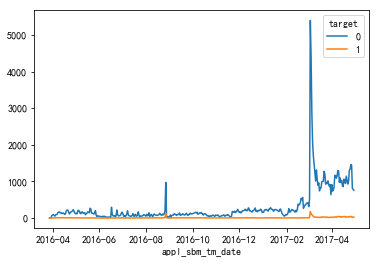

In [14]:
a = train_target.copy()
a['appl_sbm_tm_date'] = a.appl_sbm_tm.apply(lambda x: x.date())
# a =train_data_copy.groupby(['appl_sbm_tm_date'])['target'].agg({'count':'count'})
b = pd.crosstab(index=a.appl_sbm_tm_date,columns=a.target)
b.plot()
plt.show()

#### 融合多个特征表为训练集

In [15]:
train_data = pd.merge(train_target,train_auth,on=['id'],how='left')
train_data = pd.merge(train_data,train_user,on=['id'],how='left')
train_data = pd.merge(train_data,train_credit,on=['id'],how='left')
train_data['loan_hour'] = train_data['appl_sbm_tm'].map(lambda x:x.hour)
train_data['loan_day'] = train_data['appl_sbm_tm'].map(lambda x:x.day)
train_data['loan_month'] = train_data['appl_sbm_tm'].map(lambda x:x.month)
train_data['loan_year'] = train_data['appl_sbm_tm'].map(lambda x:x.year)

# 每一行的空值的个数
train_data['nan_num'] = train_data.isnull().sum(axis=1) 
# 申请贷款距离认证时的间隔天数
train_data['diff_day'] = train_data.apply(lambda row: (row['appl_sbm_tm'] - row['auth_time']).days,axis=1)
# 贷款时的年龄
train_data['how_old'] = train_data.apply(lambda row: (row['appl_sbm_tm'] - row['birthday']).days,axis=1)

train_data['是否认证时间在借贷时间前'] = train_data.apply(lambda x:0 if (x['is_auth_time_authtable'] == 0) else ( 1 if x['auth_time'] < x['appl_sbm_tm'] else 0),axis=1)
train_data['是否认证时间在借贷时间后'] = train_data.apply(lambda x:0 if (x['is_auth_time_authtable'] == 0) else ( 1 if x['auth_time'] > x['appl_sbm_tm'] else 0),axis=1)
train_data['认证时间在借贷时间前多少天'] = train_data.apply(lambda x:0 if (x['是否认证时间在借贷时间前'] == 0) else (x['appl_sbm_tm'] - x['auth_time']).days,axis=1)
train_data['认证时间在借贷时间后多少天'] = train_data.apply(lambda x:0 if (x['是否认证时间在借贷时间后'] == 0) else (x['auth_time'] - x['appl_sbm_tm']).days,axis=1)
train_data = pd.merge(train_data,bank_name_setlen,on=['id'],how='left')
train_data = pd.merge(train_data,bank_num_len,on=['id'],how='left')
train_data = pd.merge(train_data,bank_phone_num_setlen,on=['id'],how='left')
train_data = pd.merge(train_data,bank_card_type_score,on=['id'],how='left')

In [16]:
#%%为订单表建立临时表1

tmp_train_order = pd.merge(train_order, train_target, on = ['id'])
# 下单在借款前
tmp_train_order_before_appl_sbm_tm = tmp_train_order[tmp_train_order.time_order_ordertable < tmp_train_order.appl_sbm_tm]
# 下单在借款后
tmp_train_order_after_appl_sbm_tm = tmp_train_order[tmp_train_order.time_order_ordertable > tmp_train_order.appl_sbm_tm]
before_appl_sbm_tm_howmany = tmp_train_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间前有多少次购买':len})
after_appl_sbm_tm_howmany = tmp_train_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间后有多少次购买':len})
before_appl_sbm_tm_money_mean = tmp_train_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间前购买平均花费':np.mean})
after_appl_sbm_tm_money_mean = tmp_train_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间后购买平均花费':np.mean})
before_appl_sbm_tm_money_max = tmp_train_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间前购买花费最大值':np.max})
after_appl_sbm_tm_money_min = tmp_train_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间后购买花费最小值':np.min})


In [17]:
##建立银行违约率临时表

tmp_bank_target = pd.merge(train_bankcard,train_target,on=['id'])
ccc = pd.crosstab(tmp_bank_target.bank_name, tmp_bank_target.target)
ccc['违约率'] = ccc[1] / (ccc[0]+0.1)
ccc.reset_index(inplace=True)
tmp_bank_target = pd.merge(tmp_bank_target, ccc,on = ['bank_name'],how='left')
bank_name_score_mean = tmp_bank_target.groupby(by= ['id'], as_index = False)['违约率'].agg({'违约率_mean':np.mean})

In [18]:
###建立收货地违约率临时表
# tmp_recieve_target = pd.merge(train_recieve,train_target,on=['id'])
# ccc = pd.crosstab(tmp_recieve_target.first_name, tmp_recieve_target.target)
# ccc['recieve违约率'] = ccc[1] / (ccc[0]+0.1)
# ccc.reset_index(inplace=True)
# tmp_recieve_target = pd.merge(tmp_recieve_target, ccc,on = ['first_name'],how='left')
# recieve_score_mean = tmp_recieve_target.groupby(by= ['id'], as_index = False)['recieve违约率'].agg({'recieve违约率_mean':np.mean})
# train_data = pd.merge(train_data,recieve_score_mean,on=['id'],how='left')


In [19]:
train_data = pd.merge(train_data,bank_name_score_mean,on=['id'],how='left')
train_data = pd.merge(train_data,before_appl_sbm_tm_howmany,on=['id'],how='left')
train_data = pd.merge(train_data,after_appl_sbm_tm_howmany,on=['id'],how='left')
train_data = pd.merge(train_data,before_appl_sbm_tm_money_mean,on=['id'],how='left')
train_data = pd.merge(train_data,after_appl_sbm_tm_money_mean,on=['id'],how='left')
train_data = pd.merge(train_data,before_appl_sbm_tm_money_max,on=['id'],how='left')
train_data = pd.merge(train_data,after_appl_sbm_tm_money_min,on=['id'],how='left')


# train_data = pd.merge(train_data,before_appl_sbm_tm_howmany_unitprice,on=['id'],how='left')
# train_data = pd.merge(train_data,after_appl_sbm_tm_howmany_unitprice,on=['id'],how='left')
# train_data = pd.merge(train_data,before_appl_sbm_tm_money_mean_unitprice,on=['id'],how='left')
# train_data = pd.merge(train_data,after_appl_sbm_tm_money_mean_unitprice,on=['id'],how='left')
# train_data = pd.merge(train_data,before_appl_sbm_tm_money_max_unitprice,on=['id'],how='left')
# train_data = pd.merge(train_data,after_appl_sbm_tm_money_min_unitprice,on=['id'],how='left')



In [20]:
train_data.shape

(120929, 47)

In [21]:
train_data.to_csv("AI_risk_train_V3.0/train_data.csv",index=None,encoding="gb2312")

In [22]:
train_data_copy = train_data.copy()
train_data_copy.shape

(120929, 47)

In [23]:
train_data_copy = train_data_copy.fillna(0)
train_data_copy = train_data_copy[train_data_copy.appl_sbm_tm >= datetime.datetime(2017,1,1)]
train_data_copy = train_data_copy.drop(['appl_sbm_tm','id','auth_time','phone','birthday','hobby','id_card'],axis=1)
print(train_data_copy.shape)

(88078, 40)


In [24]:
def xgb_feature(train_set_x,train_set_y,test_set_x,test_set_y):
    # 模型参数
    params = {'booster': 'gbtree',
              'objective':'rank:pairwise',
              'eval_metric' : 'auc',
              'eta': 0.02,# 如同学习率
              'max_depth': 5,  # 4 3# 构建树的深度，越大越容易过拟合
              'colsample_bytree': 0.7,#0.8 # 生成树时进行的列采样
              'subsample': 0.7, # 随机采样训练样本
              'min_child_weight': 1,  # 2 3
              'silent':1# 设置成1则没有运行信息输出，最好是设置为0
              }

    dtrain = xgb.DMatrix(train_set_x, label=train_set_y)
    dvali = xgb.DMatrix(test_set_x)
    model = xgb.train(params, dtrain, num_boost_round=800)
    predict = model.predict(dvali)
    return predict

### 通过XGBoost计算各特征的重要性

In [37]:
X = train_data.copy()
X = X.drop(['appl_sbm_tm','id','auth_time','phone','birthday','hobby','id_card'],axis=1)
# X['sex'] = X['sex'].map({'保密': 0, '男': 1, '女': 2})
# X['qq_bound'] = X['qq_bound'].map({'已绑定': 1, '未绑定': 0})
# X['wechat_bound'] = X['wechat_bound'].map({'已绑定': 1, '未绑定': 0})
# X['account_grade'] = X['account_grade'].map({'注册会员': 0, '铜牌会员': 1, '银牌会员': 2, '金牌会员': 3, '钻石会员': 4})
dummy_fea = ['sex', 'merriage', 'income', 'qq_bound', 'degree', 'wechat_bound','account_grade','industry']
for _fea in dummy_fea:
    #print(_fea)
    le = LabelEncoder()
    X[_fea] = le.fit_transform(X[_fea].tolist())
X = X.fillna(0)
y = X['target']
X = X.drop(['target'],axis=1)


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000002B0B183F0F0>>
Traceback (most recent call last):
  File "c:\software\python\programs\python\python35\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [39]:
X.shape

(120929, 39)

In [40]:
from sklearn.feature_selection import SelectFromModel

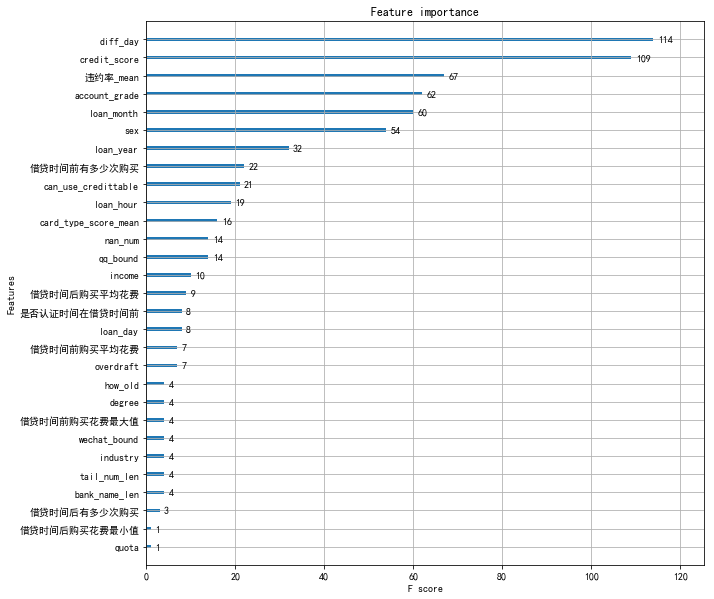

In [41]:
model = XGBClassifier()
model.fit(X, y)
# plot feature importance

fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, ax=ax)
#xgb.plot_importance(model,fi)
plt.show()


####  利用测试集通过xgb验证模型的正确率

In [46]:
#['sex', 'qq_bound', 'wechat_bound','account_grade']  :valid auc 0.8146845247722581
dummy_fea = ['sex', 'merriage', 'income', 'qq_bound', 'degree', 'wechat_bound','account_grade','industry']
dummy_df1 = pd.get_dummies(train_data.loc[:,dummy_fea])
train_data_copy1 = pd.concat([train_data,dummy_df1],axis=1)
train_data_copy1 = train_data_copy1.fillna(0)
vaild_train_data1 = train_data_copy1.drop(dummy_fea,axis=1)

# 使用贷款时间在2017-4-1之前的数据为训练集
valid_train_train1 = vaild_train_data1[vaild_train_data1.appl_sbm_tm < datetime.datetime(2017,4,1)]
# 使用贷款时间在2017-4-1之后的数据为训练集
valid_train_test1 = vaild_train_data1[vaild_train_data1.appl_sbm_tm >= datetime.datetime(2017,4,1)]

valid_train_train1 = valid_train_train1.drop(['appl_sbm_tm','id','auth_time','phone','birthday','hobby','id_card'],axis=1)
valid_train_test1 = valid_train_test1.drop(['appl_sbm_tm','id','auth_time','phone','birthday','hobby','id_card'],axis=1)
vaild_train_x1 = valid_train_train1.drop(['target'],axis=1)
vaild_test_x1 = valid_train_test1.drop(['target'],axis=1)



In [47]:
redict_result1 = xgb_feature(vaild_train_x1,valid_train_train1['target'].values,vaild_test_x1,None)
print('valid auc',roc_auc_score(valid_train_test1['target'].values,redict_result1))
sys.exit(23)


valid auc 0.8149717421354578


SystemExit: 23

### 计算auc的方法

与sklearn中的roc_auc_score函数计算结果一致

In [48]:
def cal_auc(list_one, list_two):
    '''计算AUC值'''
    positive = []
    negative = []
    for index in range(len(list_one)):
        if list_one[index] == 1:
            positive.append(index)
        else:
            negative.append(index)
    SUM = 0
    for i in positive:
        for j in negative:
            if list_two[i] > list_two[j]:
                SUM += 1
            elif list_two[i] == list_two[j]:
                SUM += 0.5
            else:
                pass
    return SUM / (len(positive)*len(negative))

In [49]:
cal_auc(valid_train_test1['target'].values,redict_result1)

0.8149717421354576

#### 测试集

In [50]:
#%%认证表特征
test_auth = pd.read_csv('AI_risk_test_V3.0/test_auth_info.csv',parse_dates = ['auth_time'])
#注册时是否有时间
test_auth['is_auth_time_authtable'] = test_auth['auth_time'].map(lambda x:0 if ((str(x).lower()=='nat')|(str(x).lower()=='nan')|(str(x)=='0000-00-00'))  else 1)
#注册时是否有idcard
test_auth['is_idcard_authtable'] = test_auth['id_card'].map(lambda x:0 if str(x).lower()=='nan' else 1)

#注册时是否有phone
test_auth['is_phone_authtable'] = test_auth['phone'].map(lambda x:0 if str(x).lower()=='nan' else 1)
test_auth['auth_time'].replace('0000-00-00',np.nan,inplace=True)
test_auth['auth_time'] = pd.to_datetime(test_auth['auth_time'])


#%%银行卡特征
test_bankcard = pd.read_csv('AI_risk_test_V3.0/test_bankcard_info.csv')
bank_name_setlen = test_bankcard.groupby(by= ['id'], as_index= False)['bank_name'].agg({'bank_name_len':lambda x:len(set(x))})
bank_num_len = test_bankcard.groupby(by= ['id'], as_index = False)['tail_num'].agg({'tail_num_len':lambda x:len(x)})
bank_phone_num_setlen = test_bankcard.groupby(by= ['id'], as_index = False)['phone'].agg({'bank_phone_num':lambda x:x.nunique()})
test_bankcard['card_type_score'] = test_bankcard['card_type'].map(lambda x:0.0154925 if x=='信用卡' else 0.02607069)
bank_card_type_score = test_bankcard.groupby(by= ['id'], as_index = False)['card_type_score'].agg({'card_type_score_mean':np.mean})

#%%信誉表特征
test_credit = pd.read_csv('AI_risk_test_V3.0/test_credit_info.csv')
#额度-使用值
test_credit['can_use_credittable'] = test_credit['quota'] - test_credit['overdraft']

#%%订单表特征
test_order = pd.read_csv('AI_risk_test_V3.0/test_order_info.csv',parse_dates=['time_order'])
test_order['amt_order_ordertable'] = test_order['amt_order'].map(lambda x:np.nan if ((x == 'NA')| (x == 'null')) else float(x))
test_order['unit_price_ordertable'] = test_order['unit_price'].map(lambda x:np.nan if ((x == 'NA')| (x == 'null')) else float(x))
test_order['time_order_ordertable'] = test_order['time_order'].map(lambda x : pd.lib.NaT if (str(x) == '0' or x == 'NA' or x == 'nan')
                            else (datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S') if ':' in str(x)
                            else (datetime.datetime.utcfromtimestamp(int(x[0:10])) + datetime.timedelta(hours = 8))))




#%%收货地址特征
test_recieve = pd.read_csv('AI_risk_test_V3.0/test_recieve_addr_info.csv')


#%%target表特征
test_target = pd.read_csv('AI_risk_test_V3.0/test_list.csv',parse_dates = ['appl_sbm_tm'])


#%%用户表特征
test_user = pd.read_csv('AI_risk_test_V3.0/test_user_info.csv')
#test_user = test_user.drop(['merriage','income','id_card','degree','industry'],axis=1)
test_user = test_user.drop(['id_card'],axis=1)
test_user['is_hobby_usertable'] = test_user['hobby'].map(lambda x:0 if str(x)=='nan' else 1)
test_user['is_birthday_usertable'] = test_user['birthday'].map(lambda x:0 if str(x)=='nan' else 1)
test_user['birthday'] = test_user['birthday'].map(lambda x:datetime.datetime.strptime(str(x),'%Y-%m-%d') if(re.match('19\d{2}-\d{1,2}-\d{1,2}',str(x)) and '-0' not in str(x)) else pd.lib.NaT)



In [51]:
test_data = pd.merge(test_target,test_auth,on=['id'],how='left')
test_data = pd.merge(test_data,test_user,on=['id'],how='left')
test_data = pd.merge(test_data,test_credit,on=['id'],how='left')
test_data['loan_hour'] = test_data['appl_sbm_tm'].map(lambda x:x.hour)
test_data['loan_day'] = test_data['appl_sbm_tm'].map(lambda x:x.day)
test_data['loan_month'] = test_data['appl_sbm_tm'].map(lambda x:x.month)
test_data['loan_year'] = test_data['appl_sbm_tm'].map(lambda x:x.year)
test_data['nan_num'] = test_data.isnull().sum(axis=1)
test_data['diff_day'] = test_data.apply(lambda row: (row['appl_sbm_tm'] - row['auth_time']).days,axis=1)
test_data['how_old'] = test_data.apply(lambda row: (row['appl_sbm_tm'] - row['birthday']).days,axis=1)
test_data['是否认证时间在借贷时间前'] = test_data.apply(lambda x:0 if (x['is_auth_time_authtable'] == 0) else ( 1 if x['auth_time'] < x['appl_sbm_tm'] else 0),axis=1)
test_data['是否认证时间在借贷时间后'] = test_data.apply(lambda x:0 if (x['is_auth_time_authtable'] == 0) else ( 1 if x['auth_time'] > x['appl_sbm_tm'] else 0),axis=1)
test_data['认证时间在借贷时间前多少天'] = test_data.apply(lambda x:0 if (x['是否认证时间在借贷时间前'] == 0) else (x['appl_sbm_tm'] - x['auth_time']).days,axis=1)
test_data['认证时间在借贷时间后多少天'] = test_data.apply(lambda x:0 if (x['是否认证时间在借贷时间后'] == 0) else (x['auth_time'] - x['appl_sbm_tm']).days,axis=1)
test_data = pd.merge(test_data,bank_name_setlen,on=['id'],how='left')
test_data = pd.merge(test_data,bank_num_len,on=['id'],how='left')
test_data = pd.merge(test_data,bank_phone_num_setlen,on=['id'],how='left')
test_data = pd.merge(test_data,bank_card_type_score,on=['id'],how='left')

In [52]:
#%%为订单表建立临时表
tmp_test_order = pd.merge(test_order, test_target, on = ['id'])
tmp_test_order_before_appl_sbm_tm = tmp_test_order[tmp_test_order.time_order_ordertable < tmp_test_order.appl_sbm_tm]
tmp_test_order_after_appl_sbm_tm = tmp_test_order[tmp_test_order.time_order_ordertable > tmp_test_order.appl_sbm_tm]
before_appl_sbm_tm_howmany = tmp_test_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间前有多少次购买':len})
after_appl_sbm_tm_howmany = tmp_test_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间后有多少次购买':len})
before_appl_sbm_tm_money_mean = tmp_test_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间前有多少次购买':np.mean})
after_appl_sbm_tm_money_mean = tmp_test_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间后有多少次购买':np.mean})
before_appl_sbm_tm_money_max = tmp_test_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间前有多少次购买最大值':np.max})
after_appl_sbm_tm_money_min = tmp_test_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['amt_order_ordertable'].agg({'借贷时间后有多少次购买最小值':np.min})

# before_appl_sbm_tm_howmany_unitprice = tmp_test_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['unit_price_ordertable'].agg({'借贷时间前有多少次购买unit_price':len})
# after_appl_sbm_tm_howmany_unitprice = tmp_test_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['unit_price_ordertable'].agg({'借贷时间后有多少次购买unit_price':len})
# before_appl_sbm_tm_money_mean_unitprice = tmp_test_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['unit_price_ordertable'].agg({'借贷时间前有多少次购买unit_price':np.mean})
# after_appl_sbm_tm_money_mean_unitprice = tmp_test_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['unit_price_ordertable'].agg({'借贷时间后有多少次购买unit_price':np.mean})
# before_appl_sbm_tm_money_max_unitprice = tmp_test_order_before_appl_sbm_tm.groupby(by=['id'],as_index=False)['unit_price_ordertable'].agg({'借贷时间前有多少次购买最大值unit_price':np.max})
# after_appl_sbm_tm_money_min_unitprice = tmp_test_order_after_appl_sbm_tm.groupby(by=['id'],as_index=False)['unit_price_ordertable'].agg({'借贷时间后有多少次购买最小值unit_price':np.min})


###建立银行违约率临时表

test_data = pd.merge(test_data,bank_name_score_mean,on=['id'],how='left')


test_data = pd.merge(test_data,before_appl_sbm_tm_howmany,on=['id'],how='left')
test_data = pd.merge(test_data,after_appl_sbm_tm_howmany,on=['id'],how='left')
test_data = pd.merge(test_data,before_appl_sbm_tm_money_mean,on=['id'],how='left')
test_data = pd.merge(test_data,after_appl_sbm_tm_money_mean,on=['id'],how='left')
test_data = pd.merge(test_data,before_appl_sbm_tm_money_max,on=['id'],how='left')
test_data = pd.merge(test_data,after_appl_sbm_tm_money_min,on=['id'],how='left')

# test_data = pd.merge(test_data,before_appl_sbm_tm_howmany_unitprice,on=['id'],how='left')
# test_data = pd.merge(test_data,after_appl_sbm_tm_howmany_unitprice,on=['id'],how='left')
# test_data = pd.merge(test_data,before_appl_sbm_tm_money_mean_unitprice,on=['id'],how='left')
# test_data = pd.merge(test_data,after_appl_sbm_tm_money_mean_unitprice,on=['id'],how='left')
# test_data = pd.merge(test_data,before_appl_sbm_tm_money_max_unitprice,on=['id'],how='left')
# test_data = pd.merge(test_data,after_appl_sbm_tm_money_min_unitprice,on=['id'],how='left')


In [53]:
test_data_copy =test_data.copy()
test_data_copy.shape

(52017, 46)

In [54]:
test_data_copy.to_csv("AI_risk_test_V3.0/test_data.csv",index=None,encoding="gb2312")

In [55]:
test_data_copy = test_data_copy.drop(['appl_sbm_tm','id','auth_time','phone','birthday','hobby','id_card'],axis=1)
test_data_copy['target'] = -1

test_data_copy.shape

(52017, 40)

In [56]:
train_data_copy.shape

(88078, 40)

In [57]:
# ['sex', 'qq_bound', 'wechat_bound','account_grade']
dummy_fea =['sex', 'merriage', 'income', 'qq_bound', 'degree', 'wechat_bound','account_grade','industry']
train_test_data = pd.concat([train_data_copy,test_data_copy],axis=0,ignore_index = True)
train_test_data = train_test_data.fillna(0)
dummy_df = pd.get_dummies(train_test_data.loc[:,dummy_fea])

train_test_data = pd.concat([train_test_data,dummy_df],axis=1)
train_test_data = train_test_data.drop(dummy_fea,axis=1)

train_train = train_test_data.iloc[:train_data_copy.shape[0],:]
test_test = train_test_data.iloc[train_data_copy.shape[0]:,:]


train_train_x = train_train.drop(['target'],axis=1)
test_test_x = test_test.drop(['target'],axis=1)


predict_result = xgb_feature(train_train_x,train_train['target'].values,test_test_x,None)

In [58]:
len(predict_result)

52017

In [59]:
ans = pd.read_csv('AI_risk_test_V3.0/test_list.csv',parse_dates = ['appl_sbm_tm'])

ans['PROB'] = predict_result
ans = ans.drop(['appl_sbm_tm'],axis=1)
minmin, maxmax = min(ans['PROB']),max(ans['PROB'])
ans['PROB'] = ans['PROB'].map(lambda x:(x-minmin)/(maxmax-minmin))
ans['PROB'] = ans['PROB'].map(lambda x:'%.4f' % x)


In [60]:
ans.to_csv('result/rebuild.csv',index=None)